# Machine Learning Classification Tutorial
By: Isaac Rosenberg


In this tutorial, we will build a neural network that takes **spectra** from the SDSS catalog and classifies whether an observation shows a star, galaxy, or quasar.

<img src="../attachments/sdss.png"  width="600"/>

[Source: SDSS](https://www.sdss.org/science/image-gallery/)

Why does that matter? The Sloan Digital Sky Survey (SDSS) has collected over four million spectra. Each spectrum is the fingerprint of a cosmic object, encoding chemical composition, temperature, physical properties, and distance. But it is impossible to manually label all of them. Automating this classification helps astronomers flag interesting outliers, and build clean training sets for future science.

We will walk through the full workflow:
- get familiar with the SDSS spectra and how they differ between object types
- prepare the data so a neural network can ingest it
- train a simple classifier and evaluate how well it can tell these sources apart

By the end, you should have an intuition for what information lives in a spectrum and why machine learning is a powerful tool for extracting it at scale.


## Exploring SDSS spectra
Before training a classifier, it helps to see what raw spectra look like. Below we grab a few examples of stars, galaxies, and quasars from the SDSS sample so you can spot the broad absorption features, sharp emission lines, and continuum shapes that set them apart.


In [184]:
### IMPORTS
import numpy as np
import matplotlib.pyplot as plt


### Loading the SDSS sample
The spectra for this tutorial are pre-packaged in a NumPy `.npy` file. Each entry stores the wavelength grid, flux values, class label, and metadata like redshift. Loading it once keeps the rest of the notebook focused on analysis instead of I/O boilerplate.


In [187]:
# Load both parts
spectra1 = np.load('../data/sdss_spectra_part1.npy', allow_pickle=True)
spectra2 = np.load('../data/sdss_spectra_part2.npy', allow_pickle=True)

# Combine into one array
spectra = np.concatenate([spectra1, spectra2], axis=0)


In [186]:
# --- Group spectra by class ---
by_class = defaultdict(list)
for s in spectra:
    by_class[s['class']].append(s)

# --- Find smallest class size ---
min_count = min(len(v) for v in by_class.values())
print("Balancing classes to", min_count, "each")

# --- Randomly sample each class to same count ---
balanced_list = []
for cls, items in by_class.items():
    balanced_list.extend(random.sample(items, min_count))

print("Total after balancing:", len(balanced_list))

spectra = balanced_list

Balancing classes to 712 each
Total after balancing: 2136


### Let's look at a few spectra
Seeing real data helps anchor the classification task. Below we group the SDSS sample by label and randomly pick three representatives of each class. Pay attention to:stars show dense absorption features, galaxies reveal broader lines plus a redder continuum, and quasars explode with strong emission lines.


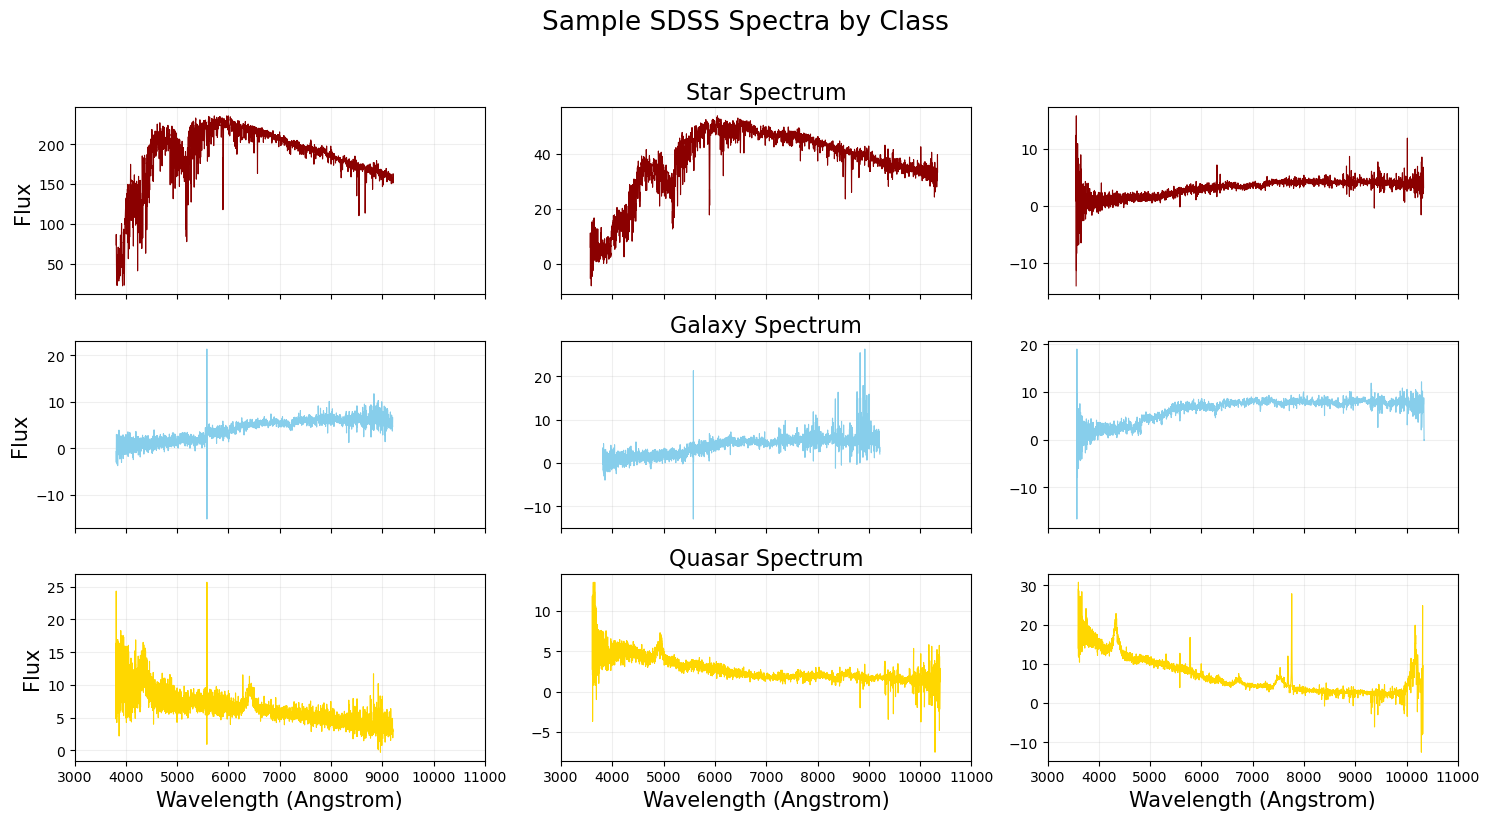

In [188]:
# Define the SDSS spectral classes we'll visualize
classes = ['STAR', 'GALAXY', 'QSO']

# Provide nicer labels for plot titles
labels = {'STAR': 'Star', 'GALAXY': 'Galaxy', 'QSO': 'Quasar'}

colors = {'STAR': 'darkred', 'GALAXY': 'skyblue', 'QSO': 'gold'}

# Group spectra by class into a dictionary.
# Each key corresponds to one class (e.g., 'STAR'),
# and each value is a list of spectra (each spectrum is a dict).
grouped = {cls: [spec for spec in spectra if spec['class'] == cls] for cls in classes}

# Create a random number generator
rng = np.random.default_rng(92)

# Create a grid of subplots: one row per class, three columns per sample
fig, axes = plt.subplots(len(classes), 3, figsize=(15, 8), sharex=True, sharey=False)

# Loop over each class (row)
for row, cls in enumerate(classes):
    available = grouped[cls]

    # Check that we have at least 3 spectra available for this class
    if len(available) < 3:
        raise ValueError(f'Not enough spectra for {cls}')

    # Randomly pick 3 unique spectra for this class
    idxs = rng.choice(len(available), size=3, replace=False)

    # Loop over the three chosen spectra and plot them
    for col, idx in enumerate(idxs):
        spec = available[idx]
        ax = axes[row, col]

        # Plot the flux vs. wavelength
        ax.plot(spec['wavelength'], spec['flux'], lw=0.8, color=colors[cls])

        # Label axes only on left and bottom panels to avoid clutter
        if row == len(classes) - 1:
            ax.set_xlabel('Wavelength (Angstrom)', fontsize=15)  # Angstroms spell out units for clarity
        if col == 0:
            ax.set_ylabel('Flux', fontsize=15)
        if col == 1:
            ax.set_title(f'{labels[cls]} Spectrum', fontsize=16)

        # Light grid and wavelength limits typical of SDSS spectra
        ax.grid(alpha=0.2)
        ax.set_xlim(3000, 11000)

# Add a figure-level title and adjust spacing
fig.suptitle('Sample SDSS Spectra by Class', fontsize=19, y=1.02)
plt.tight_layout()
plt.show()


#### Discussion: what stands out?

Qualitatively what are the differences between the three classes?


### Let's take the median


/Users/isaacrosenberg/opt/anaconda3/envs/430/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


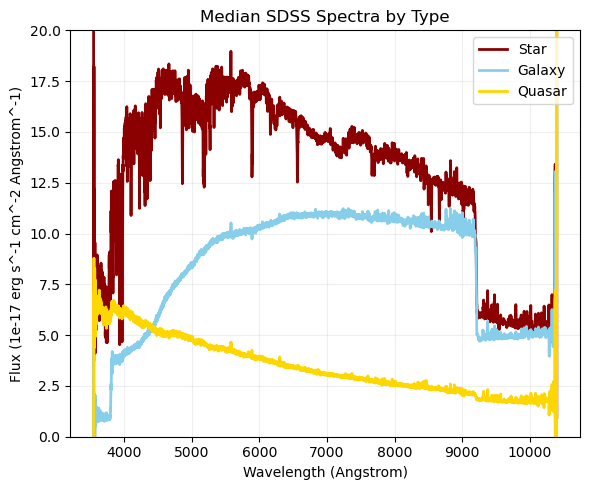

In [189]:
# Define a common wavelength grid based on all unique values
all_waves = np.unique(np.concatenate([s['wavelength'] for s in spectra]))
plt.figure(figsize=(6, 5))

for c in classes:
    specs = [s for s in spectra if s['class'] == c]
    fluxes = np.full((len(specs), len(all_waves)), np.nan)
    for i, s in enumerate(specs):
        w, f = s['wavelength'], s['flux']
        idx = np.searchsorted(all_waves, w)
        fluxes[i, idx[:len(f)]] = f
    median_flux = np.nanmedian(fluxes, axis=0)
    plt.plot(all_waves, median_flux, color=colors[c], lw=2, label=labels[c])

plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (1e-17 erg s^-1 cm^-2 Angstrom^-1)')
plt.title('Median SDSS Spectra by Type')
#plt.xlim(3800, 9200)
plt.ylim(0,20)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


#### Discussion: comparing median shapes
- How would redshift affect these shapes?
- Why does it seem like the quasar and galaxy lines are less noisy than before?
- Is all our data reliable? What cuts should we make?


In [190]:
# --- USER SETTINGS ---
lambda_min = 3800  # ### USER SETTING ### minimum wavelength (Angstrom)
lambda_max = 9200  # ### USER SETTING ### maximum wavelength (Angstrom)
# ---------------------

# Define a common wavelength grid based on all unique values
all_waves = np.unique(np.concatenate([s['wavelength'] for s in spectra]))

# --- Apply wavelength cut (user-defined) ---
mask = (all_waves >= lambda_min) & (all_waves <= lambda_max)
all_waves = all_waves[mask]
print(f"{len(all_waves)} wavelengths remaining after applying range {lambda_min}-{lambda_max} Å")


3840 wavelengths remaining after applying range 3800-9200 Å


Now it is time to start building our neural network. It will take the spectrum from SDSS and predict the object type. What should the dimensions be of the input and output?


## From spectra to neural networks
With the data inspected, we can now describe a small neural network that will classify spectra. The goal is to build reusable pieces (initialization, forward pass, loss, backpropagation) so we can experiment quickly.


### Compact neural network toolkit
The goal is to stay entirely in NumPy while still offering the usual knobs: layer widths, optional 1-D convolution, dropout, activation options, batch size, and learning rate. The next code cell defines everything in one place so experiments stay readable.


In [191]:
# ------------------------------
# 1. Prepare trimmed dataset
# ------------------------------
def prepare_dataset(spectra, classes, lambda_min=3800, lambda_max=9200, *, standardize=True):
    """
    Build a flux matrix using only wavelengths in [lambda_min, lambda_max].
    Returns:
        X        : (N, M) trimmed & standardized flux matrix
        y_int    : (N,)   integer labels
        y_onehot : (N,C)  one-hot labels
        waves    : (M,)   trimmed wavelength grid
    """
    # integer labels 0..C-1
    y_int = np.array([classes.index(s['class']) for s in spectra], dtype=int)
    num_classes = len(classes)

    # global wavelength grid
    all_waves = np.unique(np.concatenate([s['wavelength'] for s in spectra]))

    # trim to user range
    mask = (all_waves >= lambda_min) & (all_waves <= lambda_max)
    waves = all_waves[mask]
    print(f"{waves.size} wavelengths remaining after trimming to {lambda_min}-{lambda_max} Å")

    # interpolate each spectrum onto trimmed grid
    X = np.empty((len(spectra), waves.size), dtype=float)
    for i, spec in enumerate(spectra):
        X[i] = np.interp(
            waves,
            spec["wavelength"],
            spec["flux"],
            left=spec["flux"][0],
            right=spec["flux"][-1]
        )

    # standardize per wavelength
    if standardize:
        mean = X.mean(axis=0, keepdims=True)
        std  = X.std(axis=0, keepdims=True) + 1e-8
        X = (X - mean) / std

    # one-hot labels
    y_onehot = np.eye(num_classes)[y_int]

    return X.astype(np.float32), y_int, y_onehot.astype(np.float32), waves


# ------------------------------
# 2. Manual train/test split
# ------------------------------
def manual_train_test_split(X, y_int, y_onehot, *, test_fraction=0.2, seed=0):
    """
    Split manually into train/test subsets.
    Returns:
        X_train, y_train_int, y_train_onehot,
        X_test,  y_test_int,  y_test_onehot
    """
    rng = np.random.default_rng(seed)
    N = X.shape[0]
    indices = rng.permutation(N)
    test_size = int(N * test_fraction)
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]

    return (X[train_idx], y_int[train_idx], y_onehot[train_idx],
            X[test_idx],  y_int[test_idx],  y_onehot[test_idx])


In [198]:
# --- use the functions ---
classes = ['STAR', 'GALAXY', 'QSO']  # your class list

X, y_int, y_onehot, waves = prepare_dataset(
    spectra,
    classes,
    lambda_min=3800,
    lambda_max=9200,
    standardize=True
)

X_train, y_train_int, y_train_onehot, \
X_test,  y_test_int,  y_test_onehot = manual_train_test_split(
    X, y_int, y_onehot,
    test_fraction=0.2,
    seed=1
)

print("Train:", X_train.shape, y_train_int.shape, y_train_onehot.shape)
print("Test :", X_test.shape,  y_test_int.shape,  y_test_onehot.shape)


3840 wavelengths remaining after trimming to 3800-9200 Å
Train: (3960, 3840) (3960,) (3960, 3)
Test : (990, 3840) (990,) (990, 3)


In [199]:
def relu(x):
    return np.maximum(0.0, x)

def relu_grad(x):
    return (x > 0).astype(float)

def softmax(logits):
    logits = logits - logits.max(axis=1, keepdims=True)
    ex = np.exp(logits)
    return ex / ex.sum(axis=1, keepdims=True)


In [200]:
def build(input_dim, hidden_layers, output_dim,
              activation='relu',
              use_dropout=False,
              dropout_rate=0.2,
              batch_size=32,
              learning_rate=1e-3,
              seed=None):

    rng = np.random.default_rng(seed)
    params = {}
    feature_dim = input_dim

    # dense layers
    for i, width in enumerate(hidden_layers):
        params[f'W{i}'] = rng.normal(scale=np.sqrt(2.0 / feature_dim), size=(feature_dim, width))
        params[f'b{i}'] = np.zeros(width)
        feature_dim = width

    # output layer
    params['W_out'] = rng.normal(scale=np.sqrt(2.0 / feature_dim), size=(feature_dim, output_dim))
    params['b_out'] = np.zeros(output_dim)

    config = dict(
        input_dim=input_dim,
        output_dim=output_dim,
        hidden_layers=list(hidden_layers),
        activation=activation,
        use_dropout=use_dropout,
        dropout_rate=dropout_rate,
        batch_size=batch_size,
        learning_rate=learning_rate,
        seed=seed
    )

    return config, params


In [201]:
def forward(x, params, config, *, train=False, rng=None):
    cache = dict(inputs=[], preacts=[], drop_masks=[])
    out = x

    keep_prob = 1 - config['dropout_rate']

    for i, width in enumerate(config['hidden_layers']):
        cache['inputs'].append(out)
        z = out @ params[f'W{i}'] + params[f'b{i}']
        cache['preacts'].append(z)

        out = relu(z)

        # dropout
        if config['use_dropout'] and train:
            if rng is None:
                rng = np.random.default_rng()
            mask = (rng.random(out.shape) < keep_prob).astype(float) / keep_prob
            out *= mask
            cache['drop_masks'].append(mask)
        else:
            cache['drop_masks'].append(None)

    cache['final_hidden'] = out
    logits = out @ params['W_out'] + params['b_out']
    return logits, cache

def backward(probs, targets, cache, params, config):
    grads = {}
    B = targets.shape[0]

    # dL/dlogits
    dlogits = (probs - targets) / B

    # output layer grads
    H = cache['final_hidden']
    grads['W_out'] = H.T @ dlogits
    grads['b_out'] = dlogits.sum(axis=0)

    dprev = dlogits @ params['W_out'].T

    # hidden layers backward
    for i in reversed(range(len(config['hidden_layers']))):
        # dropout
        if cache['drop_masks'][i] is not None:
            dprev *= cache['drop_masks'][i]

        # relu grad
        dz = relu_grad(cache['preacts'][i]) * dprev

        X_prev = cache['inputs'][i]
        grads[f'W{i}'] = X_prev.T @ dz
        grads[f'b{i}'] = dz.sum(axis=0)

        dprev = dz @ params[f'W{i}'].T

    return grads

def train(X_train, y_train, X_test, y_test, config, params, epochs=15):
    rng = np.random.default_rng(config['seed'])
    bs = config['batch_size']
    lr = config['learning_rate']

    train_losses = []
    test_accs = []

    for epoch in range(epochs):

        # shuffle
        idx = rng.permutation(len(X_train))
        Xs = X_train[idx]
        ys = y_train[idx]

        total_loss = 0
        num_batches = int(np.ceil(len(X_train)/bs))

        for b in range(num_batches):
            start = b*bs
            end   = start+bs
            Xb = Xs[start:end]
            yb = ys[start:end]

            logits, cache = forward(Xb, params, config, train=True, rng=rng)
            probs = softmax(logits)
            loss = -np.sum(yb * np.log(probs+1e-8)) / len(Xb)
            total_loss += loss

            grads = backward(probs, yb, cache, params, config)

            # update
            for k in grads:
                params[k] -= lr * grads[k]

        avg_loss = total_loss / num_batches
        train_losses.append(avg_loss)

        # ---- evaluate ----
        logits_test, _ = forward(X_test, params, config, train=False)
        probs_test = softmax(logits_test)
        preds = np.argmax(probs_test, axis=1)
        truth = np.argmax(y_test, axis=1)
        acc = (preds == truth).mean() * 100
        test_accs.append(acc)

        print(f"Epoch {epoch+1}/{epochs} | Loss {avg_loss:.4f} | Test Acc: {acc:.2f}%")

    return params, train_losses, test_accs


In [202]:
config, params = build(
    input_dim=X_train.shape[1],
    hidden_layers=[256, 10, 10],
    output_dim=len(classes),
    use_dropout=False,
    dropout_rate=0.1,
    batch_size=20,
    learning_rate=1e-2,
    seed=11199
)


In [203]:
params, losses, accs = train(
    X_train, y_train,
    X_test,  y_test,
    config, params,
    epochs=15
)

Epoch 1/15 | Loss 0.7716 | Test Acc: 70.91%
Epoch 2/15 | Loss 0.6410 | Test Acc: 76.97%
Epoch 3/15 | Loss 0.5616 | Test Acc: 78.89%
Epoch 4/15 | Loss 0.5287 | Test Acc: 74.75%
Epoch 5/15 | Loss 0.4745 | Test Acc: 87.47%
Epoch 6/15 | Loss 0.3979 | Test Acc: 91.31%
Epoch 7/15 | Loss 0.3592 | Test Acc: 88.38%
Epoch 8/15 | Loss 0.3489 | Test Acc: 87.88%
Epoch 9/15 | Loss 0.3265 | Test Acc: 88.79%
Epoch 10/15 | Loss 0.3231 | Test Acc: 89.90%
Epoch 11/15 | Loss 0.2917 | Test Acc: 93.23%
Epoch 12/15 | Loss 0.2714 | Test Acc: 88.79%
Epoch 13/15 | Loss 0.2709 | Test Acc: 92.32%
Epoch 14/15 | Loss 0.2680 | Test Acc: 91.21%
Epoch 15/15 | Loss 0.2490 | Test Acc: 91.11%


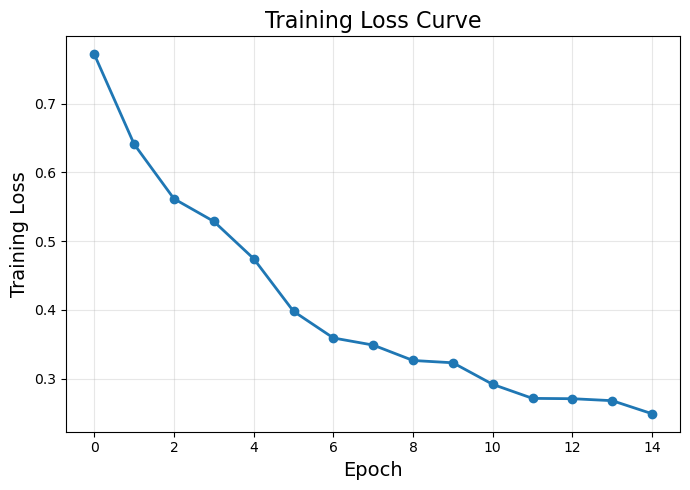

In [183]:
plt.figure(figsize=(7,5))
plt.plot(losses, marker='o', linewidth=2)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Training Loss", fontsize=14)
plt.title("Training Loss Curve", fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()